In [46]:
import os #Librería para verificar la existencia del archivo CSV
import pandas as pd #Librería para analizar y manipular DataFrames
#import numpy as np #Librería para númericas avanzadas
import missingno as msn #librería para manejar los valores nulos
import matplotlib.pyplot as plt #Librería para gráficar los resultados
import seaborn as sns

In [47]:
archivoCSV = "Readmissions_and_Deaths_-_Hospital.csv" #Nombre del archivo.
assert os.path.exists(archivoCSV), f"No se encuentra el archivo {archivoCSV}" #Verificamos si existe el archivo

In [48]:
df = pd.read_csv(archivoCSV) #Los datos del archivo se almacenan en la variable DF

In [49]:
#1. Primero exploraremos los datos del CSV

print(df.shape) #Sirve para ver la dimensión de los datos (Filas x Columnas)
print(df.info()) #Nos muestra las columnas con su: Nombre, Tipo de datos, Cantidad de valores NO NULOS,
#Se puede ver que el 80% de los tipos de datos son: "object" o "string", y el otro 20% son "int" o númericos

(64764, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64764 entries, 0 to 64763
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 64764 non-null  int64 
 1   Provider ID           64764 non-null  int64 
 2   Hospital Name         64764 non-null  object
 3   Address               64764 non-null  object
 4   City                  64764 non-null  object
 5   State                 64764 non-null  object
 6   ZIP Code              64764 non-null  int64 
 7   County Name           64582 non-null  object
 8   Phone Number          64764 non-null  int64 
 9   Measure Name          64764 non-null  object
 10  Measure ID            64764 non-null  object
 11  Compared to National  64764 non-null  object
 12  Denominator           64764 non-null  object
 13  Score                 64764 non-null  object
 14  Lower Estimate        64764 non-null  object
 15  Higher Estimate       64

In [50]:
#Ahora exploraremos los valores nulos del DataFrame
cantNulos = df.isnull().sum() #Cantidad de valores nulos.
porNulos = (cantNulos / len(df)) * 100 # Porcentaje de valores nulos.

#Mostramos solo las columnas que tienen valores nulos
print(cantNulos[cantNulos > 0].sort_values(ascending=False))
#Mostramos las mismas columnas de antes, pero no con la cantidad total, sino con el porcentaje de toda la columna
print(porNulos[porNulos > 0].sort_values(ascending=False))

Footnote       41785
County Name      182
dtype: int64
Footnote       64.518869
County Name     0.281020
dtype: float64


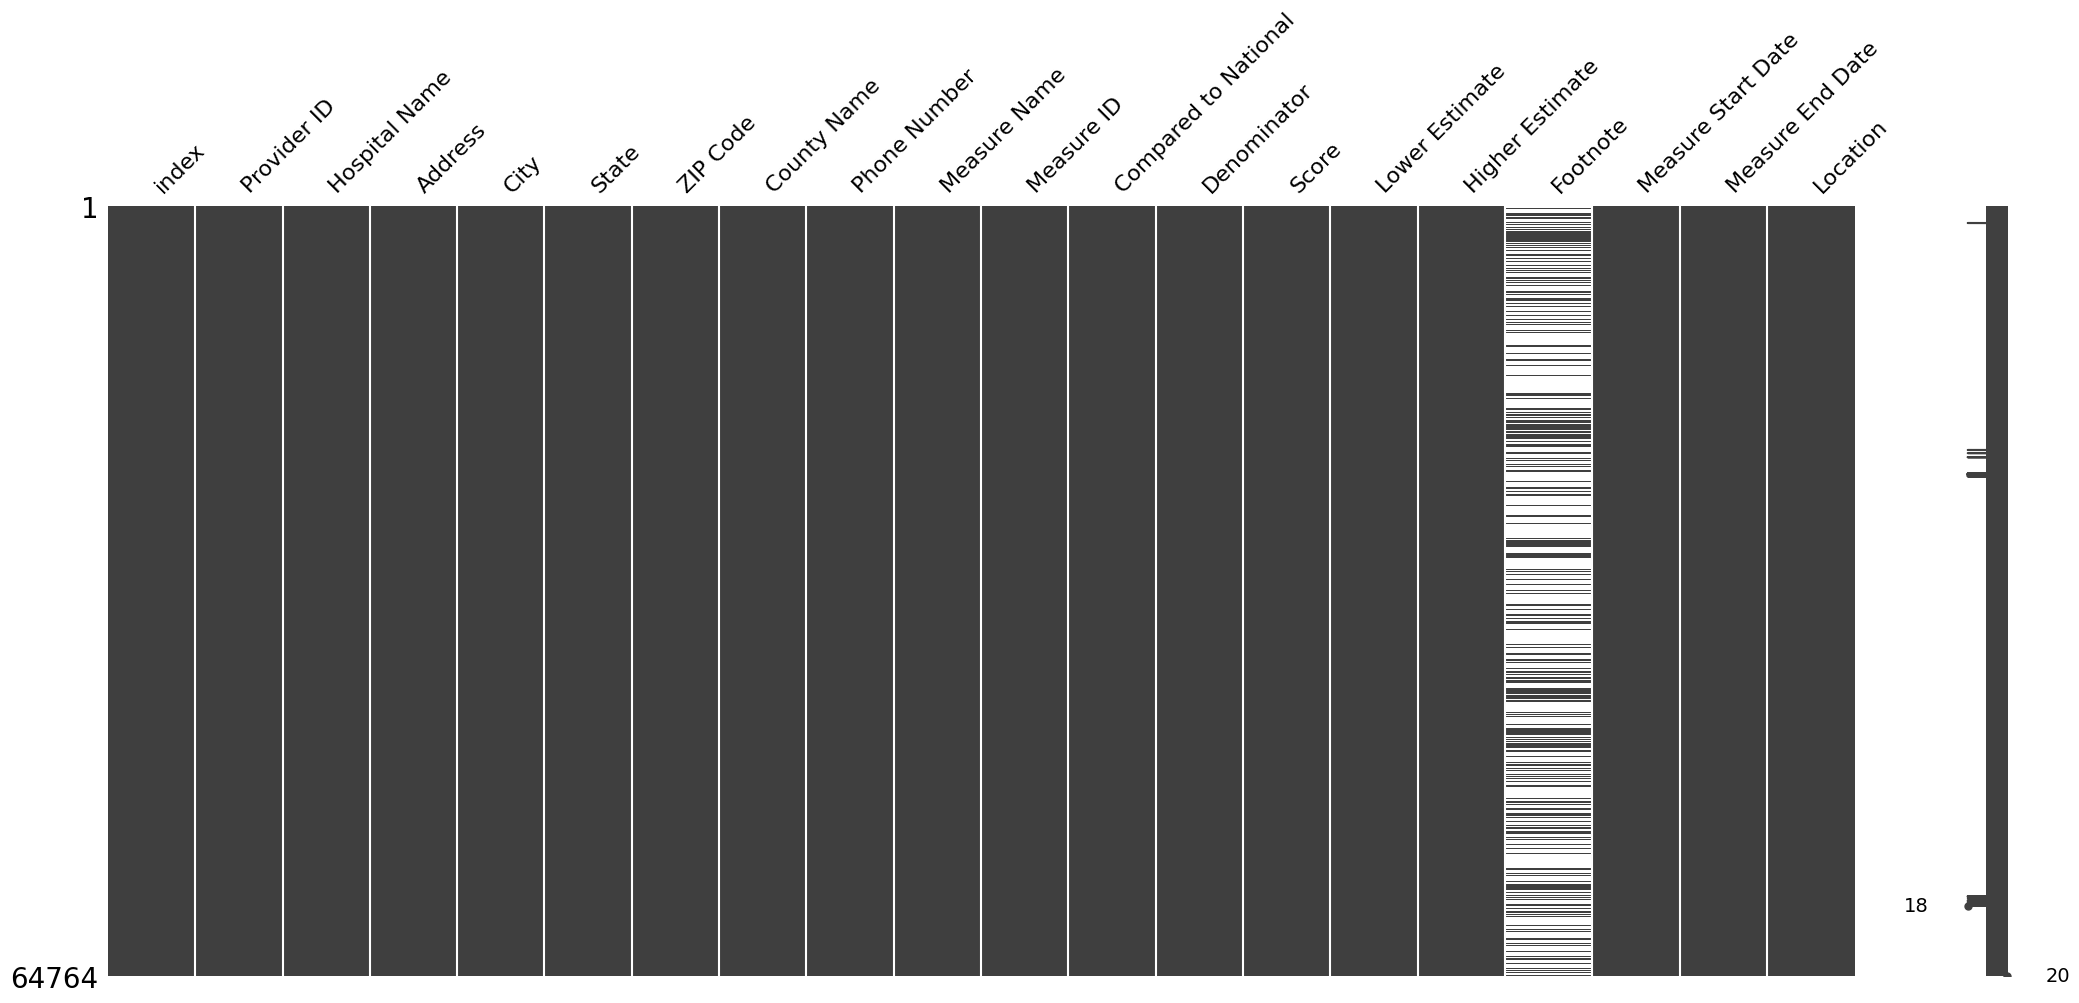

In [51]:
msn.matrix(df)
plt.show()

In [52]:
#Guardamos una copia del archivo original, en caso de complicaciones
dfCopia = df.copy()

In [53]:
#2. Conversión de datos

dfCopia['Score'] = pd.to_numeric(dfCopia['Score'], errors='coerce') #Puntuación a númerico
dfCopia['Measure Start Date'] = pd.to_datetime(dfCopia['Measure Start Date'], errors='coerce') #Start Date a DateTime
dfCopia['Measure End Date'] = pd.to_datetime(dfCopia['Measure End Date'], errors='coerce') #End Date a DateTime

#Revisión de datos nulos, después de la transformación de datos.
print(dfCopia[['Score','Measure Start Date','Measure End Date']].isna().sum())

#Revisión de valores no convertidos en Score
print(dfCopia.loc[dfCopia['Score'].isnull(), 'Score'].unique()[:10])

Score                 22979
Measure Start Date        0
Measure End Date          0
dtype: int64
[nan]


In [54]:
print("Start:", dfCopia['Measure Start Date'].min(), "->", dfCopia['Measure Start Date'].max())
print("End:  ", dfCopia['Measure End Date'].min(), "->", dfCopia['Measure End Date'].max())

# Fechas incoherentes (Start > End)
bad_dates = dfCopia[dfCopia['Measure Start Date'] > dfCopia['Measure End Date']]
print("\nRegistros con fechas incoherentes:", len(bad_dates))

# Revisar posibles outliers en Score
print("\nResumen estadístico de Score:")
print(dfCopia['Score'].describe())

Start: 2012-07-01 00:00:00 -> 2014-07-01 00:00:00
End:   2015-06-30 00:00:00 -> 2015-06-30 00:00:00

Registros con fechas incoherentes: 0

Resumen estadístico de Score:
count    41785.000000
mean        14.512662
std          4.953454
min          1.400000
25%         12.100000
50%         15.200000
75%         17.600000
max         31.300000
Name: Score, dtype: float64


In [55]:
# 1) Guardar original por si acaso
dfCopia['Score_orig'] = dfCopia['Score'].astype(str)

# 2) ¿Cuántos NaN produjo la coerción inicial?
print("Score numérico no nulos (tras primera coerción):", dfCopia['Score'].notna().sum())
print("Score numérico nulos (tras primera coerción):", dfCopia['Score'].isna().sum())
print("Total filas:", len(dfCopia))

# 3) ¿Qué valores originales no se convirtieron? (top)
bad_score_vals = dfCopia.loc[dfCopia['Score'].isna(), 'Score_orig']
print("\nTop valores originales que quedaron como NaN (muestra y conteo):")
print(bad_score_vals.value_counts().head(50))

# 4) Limpiar símbolos comunes y crear flag de censura
dfCopia['Score_clean'] = dfCopia['Score_orig'].str.strip()

# Mapear textos típicos a NaN (ajusta si ves otros)
to_null = ['Not Available','N/A','NA','--','null','<null>','None','None ']
dfCopia['Score_clean'] = dfCopia['Score_clean'].replace(to_null, pd.NA)

# Flag si contenía '<' o '>'
dfCopia['Score_censored'] = dfCopia['Score_clean'].str.contains(r'[<>]', na=False)

# Eliminar < y > y comas como separador decimal
dfCopia['Score_clean'] = dfCopia['Score_clean'].astype(str).str.replace(r'[<>]', '', regex=True)
dfCopia['Score_clean'] = dfCopia['Score_clean'].str.replace(',', '.', regex=False)
dfCopia['Score_clean'] = dfCopia['Score_clean'].replace('nan', pd.NA)  # limpiar strings 'nan'

# 5) Reconversión a numérico
dfCopia['Score_num2'] = pd.to_numeric(dfCopia['Score_clean'], errors='coerce')

print("\nDespués de limpieza:")
print("Score_num2 no nulos:", dfCopia['Score_num2'].notna().sum())
print("Score_num2 nulos:", dfCopia['Score_num2'].isna().sum())
print("Cant. marcados como censurados (contenían < o >):", dfCopia['Score_censored'].sum())

print("\nSi siguen habiendo no convertidos, muéstralos:")
print(dfCopia.loc[dfCopia['Score_num2'].isna(), 'Score_clean'].value_counts().head(50))

# 6) Estadísticas y outliers (IQR) sobre Score_num2
s = dfCopia['Score_num2'].dropna()
if len(s) > 0:
    print("\nResumen estadístico Score_num2:")
    print(s.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))
    q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
    lower = q1 - 1.5 * iqr; upper = q3 + 1.5 * iqr
    print(f"\nIQR: {iqr:.4f}  lower: {lower:.4f}  upper: {upper:.4f}")
    out_mask = (dfCopia['Score_num2'] < lower) | (dfCopia['Score_num2'] > upper)
    print("Outliers IQR detectados:", out_mask.sum())
    display(dfCopia.loc[out_mask, ['Score_orig','Score_clean','Score_num2','Score_censored','Measure Name','Hospital Name']].head(30))
else:
    print("No hay valores numéricos para Score_num2.")

# 7) Inspección rápida de Start/End (conteos)
print("\nTop 10 Measure Start Date (raw):")
print(dfCopia['Measure Start Date'].value_counts().head(10))

print("\nTop 10 Measure End Date (raw):")
print(dfCopia['Measure End Date'].value_counts().head(10))

print("\nTop 10 Start_parsed (si existe):")
if 'Start_parsed' in dfCopia.columns:
    print(dfCopia['Start_parsed'].value_counts().head(20))
else:
    # si no creaste parsed antes, crea versiones parseadas (no destructivas)
    dfCopia['Start_parsed'] = pd.to_datetime(dfCopia['Measure Start Date'], errors='coerce')
    dfCopia['End_parsed']   = pd.to_datetime(dfCopia['Measure End Date'], errors='coerce')
    print(dfCopia['Start_parsed'].value_counts().head(20))
    print("\nTop 10 End_parsed:")
    print(dfCopia['End_parsed'].value_counts().head(20))

# 8) Guardar un reporte rápido (opcional)
report = pd.DataFrame({
    'total_rows': [len(dfCopia)],
    'score_num2_notnull': [dfCopia['Score_num2'].notna().sum()],
    'score_num2_null': [dfCopia['Score_num2'].isna().sum()],
    'score_censored': [dfCopia['Score_censored'].sum()],
    'start_parsed_null': [dfCopia['Start_parsed'].isna().sum()],
    'end_parsed_null': [dfCopia['End_parsed'].isna().sum()]
})
display(report)


Score numérico no nulos (tras primera coerción): 41785
Score numérico nulos (tras primera coerción): 22979
Total filas: 64764

Top valores originales que quedaron como NaN (muestra y conteo):
Score_orig
nan    22979
Name: count, dtype: int64

Después de limpieza:
Score_num2 no nulos: 41785
Score_num2 nulos: 22979
Cant. marcados como censurados (contenían < o >): 0

Si siguen habiendo no convertidos, muéstralos:
Series([], Name: count, dtype: int64)

Resumen estadístico Score_num2:
count    41785.000000
mean        14.512662
std          4.953454
min          1.400000
1%           3.000000
5%           4.500000
25%         12.100000
50%         15.200000
75%         17.600000
95%         21.900000
99%         23.800000
max         31.300000
Name: Score_num2, dtype: float64

IQR: 5.5000  lower: 3.8500  upper: 25.8500
Outliers IQR detectados: 1025


,Score_orig,Score_clean,Score_num2,Score_censored,Measure Name,Hospital Name
30,3.4,3.4,3.4,False,Death rate for CABG,"BEAUMONT HOSPITAL, ROYAL OAK"
42,3.8,3.8,3.8,False,Rate of readmission after hip/knee replacement,TAWAS ST JOSEPH HOSPITAL
62,26.9,26.9,26.9,False,Heart failure (HF) 30-Day Readmission Rate,BEAUMONT HOSPITAL - WAYNE
66,3.2,3.2,3.2,False,Death rate for CABG,MCLAREN FLINT
93,3.3,3.3,3.3,False,Death rate for CABG,BORGESS MEDICAL CENTER
309,3.7,3.7,3.7,False,Death rate for CABG,GADSDEN REGIONAL MEDICAL CENTER
333,2.6,2.6,2.6,False,Death rate for CABG,MCLAREN GREATER LANSING
374,3.5,3.5,3.5,False,Death rate for CABG,ST JOHN MACOMB-OAKLAND HOSPITAL-MACOMB CENTER
410,3.6,3.6,3.6,False,Death rate for CABG,FLOWERS HOSPITAL
489,3.4,3.4,3.4,False,Death rate for CABG,MIDMICHIGAN MEDICAL CENTER-MIDLAND



Top 10 Measure Start Date (raw):
Measure Start Date
2012-07-01    60138
2014-07-01     4626
Name: count, dtype: int64

Top 10 Measure End Date (raw):
Measure End Date
2015-06-30    64764
Name: count, dtype: int64

Top 10 Start_parsed (si existe):
Start_parsed
2012-07-01    60138
2014-07-01     4626
Name: count, dtype: int64

Top 10 End_parsed:
End_parsed
2015-06-30    64764
Name: count, dtype: int64


,total_rows,score_num2_notnull,score_num2_null,score_censored,start_parsed_null,end_parsed_null
0,64764,41785,22979,0,0,0


In [57]:
import pandas as pd
import numpy as np

# 0) Asume que dfCopia ya existe y contiene Score_orig si lo guardaste antes.
# Si no, crea Score_orig:
if 'Score_orig' not in dfCopia.columns:
    dfCopia['Score_orig'] = dfCopia['Score'].astype(str)

# 1) Normalizar textos que indican no-disponible
to_null = ['Not Available','Not available','NOT AVAILABLE','N/A','NA','--','null','<null>','None','']
dfCopia['Score_clean'] = dfCopia['Score_orig'].str.strip().replace(to_null, pd.NA)

# 2) Limpiar símbolos y comas decimales si existen
dfCopia['Score_clean'] = dfCopia['Score_clean'].astype(str).str.replace(r'[<>]', '', regex=True)
dfCopia['Score_clean'] = dfCopia['Score_clean'].str.replace(',', '.', regex=False)
# Reconvertir strings 'nan' a NA
dfCopia['Score_clean'] = dfCopia['Score_clean'].replace({'nan': pd.NA, 'None': pd.NA})

# 3) Primer recuento de NAs
total = len(dfCopia)
n_null_clean = dfCopia['Score_clean'].isna().sum()
print(f"Total filas: {total}")
print(f"Nulos en Score tras normalizar 'Not Available' y similares: {n_null_clean} -> {n_null_clean/total*100:.2f}%")

# 4) Convertir a numérico (segunda conversión) y ver cuántos se recuperaron
dfCopia['Score_num2'] = pd.to_numeric(dfCopia['Score_clean'], errors='coerce')
print("Score_num2 no nulos:", dfCopia['Score_num2'].notna().sum())
print("Score_num2 nulos:", dfCopia['Score_num2'].isna().sum())

# 5) Detectar outliers con IQR (igual que antes)
s = dfCopia['Score_num2'].dropna()
q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
lower = q1 - 1.5 * iqr; upper = q3 + 1.5 * iqr
out_mask = (dfCopia['Score_num2'] < lower) | (dfCopia['Score_num2'] > upper)
print(f"IQR bounds: lower={lower:.3f}, upper={upper:.3f}; outliers IQR: {out_mask.sum()}")

# 6) Preparar mapeos de media por (Measure ID, State) y fallback por Measure ID
group_counts = dfCopia.groupby(['Measure ID','State'])['Score_num2'].agg(['count','mean']).reset_index().rename(columns={'count':'n_obs','mean':'mean_score'})
measure_state_mean = group_counts.set_index(['Measure ID','State'])['mean_score'].to_dict()
measure_mean = dfCopia.groupby('Measure ID')['Score_num2'].mean().to_dict()
global_mean = dfCopia['Score_num2'].mean()

# 7) Función de imputación y aplicación (no sobreescribe Score_num2)
def impute_score(row):
    if pd.notna(row['Score_num2']):
        return row['Score_num2']
    key = (row['Measure ID'], row['State'])
    if key in measure_state_mean and not pd.isna(measure_state_mean[key]):
        return measure_state_mean[key]
    if row['Measure ID'] in measure_mean and not pd.isna(measure_mean[row['Measure ID']]):
        return measure_mean[row['Measure ID']]
    return global_mean

dfCopia['Score_imputed'] = dfCopia.apply(impute_score, axis=1)

# 8) Winsorize 1%-99%
p_low = dfCopia['Score_imputed'].quantile(0.01)
p_high = dfCopia['Score_imputed'].quantile(0.99)
dfCopia['Score_winsor'] = dfCopia['Score_imputed'].clip(lower=p_low, upper=p_high)

# 9) Reporte final resumido
print("\nResumen antes/después:")
print(" - Score_num2 (no-nulos):", dfCopia['Score_num2'].notna().sum())
print(" - Score_imputed (no-nulos):", dfCopia['Score_imputed'].notna().sum())
print(f" - Winsorize bounds (1%/99%): {p_low:.3f} / {p_high:.3f}")

print("\nDescribe Score_num2 (antes):")
print(dfCopia['Score_num2'].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))

print("\nDescribe Score_winsor (después):")
print(dfCopia['Score_winsor'].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]))

# 10) Guardar un CSV con ejemplos para revisar manualmente (opcional)
dfCopia[['Provider ID','Hospital Name','State','Measure ID','Measure Name',
         'Score_orig','Score_clean','Score_num2','Score_imputed','Score_winsor']].to_csv('score_impute_winsor_examples.csv', index=False)
print("\nGuardado: score_impute_winsor_examples.csv (muestra con antes/después)")


Total filas: 64764
Nulos en Score tras normalizar 'Not Available' y similares: 22979 -> 35.48%
Score_num2 no nulos: 41785
Score_num2 nulos: 22979
IQR bounds: lower=3.850, upper=25.850; outliers IQR: 1025

Resumen antes/después:
 - Score_num2 (no-nulos): 41785
 - Score_imputed (no-nulos): 64764
 - Winsorize bounds (1%/99%): 2.900 / 23.300

Describe Score_num2 (antes):
count    41785.000000
mean        14.512662
std          4.953454
min          1.400000
1%           3.000000
5%           4.500000
25%         12.100000
50%         15.200000
75%         17.600000
95%         21.900000
99%         23.800000
max         31.300000
Name: Score_num2, dtype: float64

Describe Score_winsor (después):
count    64764.000000
mean        13.705217
std          5.199487
min          2.900000
1%           2.900000
5%           3.504286
25%         11.746429
50%         14.600000
75%         16.868182
95%         21.600000
99%         23.300000
max         23.300000
Name: Score_winsor, dtype: float64


(array([0.19047619, 0.38095238, 0.57142857, 0.19047619]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <BarContainer object of 4 artists>)

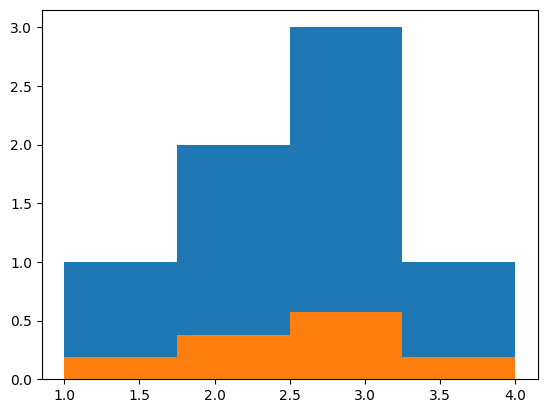

In [2]:
import matplotlib.pyplot as plt
plt.hist([1,2,2,3,3,3,4], bins=4, density=False)  # cuenta: 1,2,3,1
plt.hist([1,2,2,3,3,3,4], bins=4, density=True)   # densidad: 0.125, 0.25, 0.375, 0.125
